<a href="https://colab.research.google.com/github/SarahGhysels/SarahGhysels_thesis_2024/blob/Thesis/ThesisSarahGhysels__RF_Threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Random forest model

## Installing necessary functions

In [ ]:
%pip install mahotas
%pip install Augmentor
%pip install split-folders tqdm
%pip uninstall -y numpy #these 4 lines were added because of an error with loading the LabelEncoder
%pip uninstall -y setuptools
%pip install numpy
%pip install setuptools
#don't forget to click restart runtime here!

In [ ]:
import itertools
import numpy as np
import mahotas
import cv2
import os
import matplotlib.pyplot as plt
import Augmentor
import pandas as pd
import random
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from google.colab import files
import shutil
from sklearn.model_selection import GridSearchCV
import re
import splitfolders
from math import copysign
from sklearn.feature_selection import SelectFromModel
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Creating functions for later use

### Features extraction

In [ ]:
# FUNCTION TO CALCULATE LEARNABLE FEATURES IN IMAGES


# features description -1:  Hu Moments
def fd_hu_moments(image):
    #thresholding with geen pixel mask
    blue, green, red = cv2.split(image)
    basic=(blue<65) & (green>80)
    dark= (blue<40) & (green>35) & (red <45)
    lightmedium= (blue>50) & (blue<100) &(green>110) & (red >70)& (red <130)
    lightvery = (blue>50) & (blue<140) &(green>150) & (red >80)& (red <160)
    newimg=basic+dark+lightvery+lightmedium
    thres = np.multiply(newimg, 1, dtype='uint8' )
    #Hu moments
    feature = cv2.HuMoments(cv2.moments(thres)).flatten()
    for i in range(0,7):
      if feature[i] !=0:
        feature[i] = -1* copysign(1.0, feature[i]) * np.log10(abs(feature[i]))
    return feature

# feature-descriptor -2: Haralick Texture
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

# feature-description -3: Color Histogram
def fd_histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COMPUTE THE COLOR HISTOGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[8,8,8], [0, 180, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histogram
    return hist.flatten()

#feature-description -4: sum green pixels as feature
def fd_greenpixels(image):
  #First green counter
  blue, green, red = cv2.split(image)
  basic=(blue<65) & (green>80)
  dark= (blue<40) & (green>35) & (red <45)
  lightmedium= (blue>50) & (blue<100) &(green>110) & (red >70)& (red <130)
  lightvery = (blue>50) & (blue<140) &(green>150) & (red >80)& (red <160)
  newimg=basic+dark+lightvery+lightmedium
  sumpixels=newimg.sum()
  #Second green counter
  newimg2 = (green>(blue+20))&(green>(red+15))
  sumpixels2 = newimg2.sum()
  return sumpixels, sumpixels2

#feature-description -5: sum green pixels as feature
def fd_vegindices(image): #these come from https://isprs-archives.copernicus.org/articles/XLII-3/1215/2018/isprs-archives-XLII-3-1215-2018.pdf
#   this paper also uses these: https://www.sciencedirect.com/science/article/pii/S1470160X16301406?casa_token=8wIIrswmqc8AAAAA:tr0iQCh7kW4ZjbWMLckAAPwQpYsF2GFS3ERnglxFSrYd8C8-WVuREf83BPYjv391ZAlpsz9mPFY
  blue, green, red = cv2.split(image)
  RGBVI = (np.multiply(green, green, dtype=np.uint32) - np.multiply(red, blue, dtype=np.uint32))/(np.multiply(green, green, dtype=np.uint32)+np.multiply(red, blue,dtype=np.uint32 ))
  GLI = ((np.multiply(green,2,dtype=np.uint16 ) - red - blue)/(np.multiply(green,2,dtype=np.uint16 ) +red+blue))
  VARI = ((green-red)/(np.add(red, green, dtype = np.uint16)-blue))
  NGRDI = ((green-red)/(np.add(red, green, dtype = np.uint16)))
  combo = [np.mean(RGBVI), np.mean(GLI), np.mean(VARI), np.mean(NGRDI)]
  return combo

### Oversampling

In [ ]:
#Function to generate extra data by oversampling
def oversample_func(split_directory, folders, target_folders, requiredNbrOfImages):
    for i in range(len(folders)):
        path, dirs, files = next(os.walk(folders[i]))
        nbrOfImages = len(files)
        nbrOfImagesNeeded = requiredNbrOfImages - nbrOfImages
        seed = random.randint(0, 1000)

        if nbrOfImagesNeeded > 0:
            tfd = target_folders[i]
            print ("saving in " + tfd)
            p = Augmentor.Pipeline(source_directory=folders[i], output_directory=tfd)
            p.set_seed(seed)
            p.flip_left_right(probability=0.5)
            p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
            p.flip_left_right(probability=0.5)
            p.sample(nbrOfImagesNeeded, multi_threaded=False)

## Using the model

### Reading in data

In [ ]:
main_path='/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Train'
split_path= '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split'
train_path = split_path + "/train"
val_path = split_path + "/val"
oversample_path='/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/OversampleThresh'
output_path='/content/drive/MyDrive/Sarah_Ghysels_Thesis/OutputRF'

In [ ]:
#reading in the y data
Dataset_multigras= pd.read_csv('/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/Multigras_data.csv', sep=';')
DMY = Dataset_multigras['DMY (kg/ha)']
DMY_int=[]
for i in range(0,len(DMY)):
   try: DMY_int.append(int(DMY[i]))
   except ValueError: DMY_int.append(-544)


### Creating paths and oversampling

In [ ]:
#setting up model directory
#split folder verwijderen
!rm -rf '{split_path}'
#regression folder verwijderen
!rm -rf '{oversample_path}'
#output folder verwijderen en opnieuw aanmaken
!rm -rf '{output_path}'
os.makedirs(output_path)
#Nieuwe split doen op de folders
splitfolders.ratio(main_path, output=split_path, seed=382, ratio=(0.8, 0.2), group_prefix=None, move=False)

Copying files: 3772 files [02:03, 30.52 files/s]


In [ ]:
# #oversample
# target_dir = train_path
# dir=target_dir
# folders = [os.path.join(dir, folder) for folder in next(os.walk(dir))[1]]
# target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(dir))[1]]
# oversample_func(split_path,  folders, target_folders, 2720)

### Feature extracting and combining with DMY values

In [ ]:
#determining threshold
#First transforming all values to integers and transforming error to negative number other errors are denoted with
DMY_int=[]
for i in range(0,len(DMY)):
   try: DMY_int.append(int(DMY[i]))
   except ValueError: DMY_int.append(-544)

DMY_int.sort()
Top10percent = round(9*4224/10)
threshold = DMY_int[Top10percent]
print(threshold)

6811


In [ ]:
#creating datasets
# read the training data labels
train_labels = os.listdir(train_path)
# sort the training labesl
train_labels.sort()
# empty list to hold feature vectors and labels
features_train = []
y_values_train = []

# loop over the training data sub folder
for training_name in train_labels:
  # join the training data path and each training folder
  dir = os.path.join(train_path, training_name)

  # loop over the images in each sub-folder
  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= int(DMY[index])
    except ValueError:y=-1
    if y>=threshold: y = 1
    elif y>-1 and y<threshold: y = 0

    file = dir + "/" + os.fsdecode(file)
    # read the image and compute features
    image = cv2.imread(file)

    image = cv2.resize(image,tuple((51, 51)))
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    fv_greenpixels= fd_greenpixels(image)
    fv_vegindices = fd_vegindices(image)

    # Concatenate global features
    global_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices])

    # update the list of labels and feature vectors
    if (y>-1):
      y_values_train.append(y)
      features_train.append(global_feature)

print("Completed Training Set Feature Extraction...")

#creating datasets
# read the validation data labels
val_labels = os.listdir(val_path)
# sort the validation labels
val_labels.sort()
# empty list to hold feature vectors and labels
features_val = []
y_values_val = []

# loop over the validation data sub folder
for val_name in val_labels:
  # join the validation data path and each validation folder
  dir = os.path.join(val_path, val_name)

  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= int(DMY[index])
    except ValueError:y=-1
    if y>=threshold: y = 1 #changed
    elif y>-1 and y<threshold: y = 0

    file = dir + "/" + os.fsdecode(file)
    # read the image and compute features
    image = cv2.imread(file)

    image = cv2.resize(image, tuple((51, 51)))
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    fv_greenpixels= fd_greenpixels(image)
    fv_vegindices = fd_vegindices(image)

    # Concatenate global features
    global_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices ])

    # update the list of labels and feature vectors
    if (y>-1):                                 # & (y<10000)
      y_values_val.append(y)
      features_val.append(global_feature)

print("Completed Validation Set Feature Extraction...")

#creating datasets
#creating X datasets
X_train=np.array(features_train)
X_val=np.array(features_val)

#creating y datasets
y_train =y_values_train
y_val = y_values_val

Completed Training Set Feature Extraction...
Completed Validation Set Feature Extraction...


### Creating and tuning the model

In [ ]:
# #creating the model and hyperparameter tuning
# forest  = RandomForestClassifier(n_estimators=250, max_features='sqrt') #max features is the amount of features for each split
# parameter_grid_forest = {
#   "criterion": ['gini', 'entropy', 'log_loss'], #'gini', 'entropy', 'log_loss'
#   "max_depth": [3,5,7],
#   "ccp_alpha": np.logspace(-3, 0, 10)
#   }

# grid_forest = GridSearchCV(forest, parameter_grid_forest, scoring='balanced_accuracy')
# grid_forest.fit(X_train,y_train)
# print('The best parameters are: {}'.format(grid_forest.best_params_))

The best parameters are: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 7}


Train balanced Accuracy 0.8436 
Validation balanced Accuracy 0.8361 
Validation F2 score 0.6688 


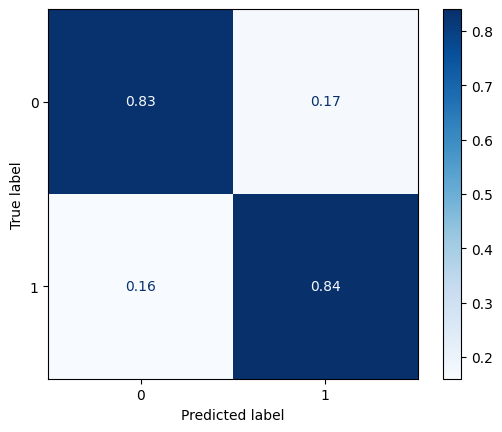

In [ ]:
#testing the optimized model
forest_opt= RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion = 'entropy',max_depth=5,ccp_alpha=0.001 ,class_weight='balanced')
forest_opt.fit(X_train, y_train)

Y_pred_train = forest_opt.predict(X_train)
train_accuracy = metrics.balanced_accuracy_score(y_train, Y_pred_train)
Y_pred=forest_opt.predict(X_val)
val_accuracy = metrics.balanced_accuracy_score(y_val, Y_pred)
F2_score = metrics.fbeta_score(y_val, Y_pred, beta=2)
print("Train balanced Accuracy {:.4f} ".format(train_accuracy))
print("Validation balanced Accuracy {:.4f} ".format(val_accuracy))
print("Validation F2 score {:.4f} ".format(F2_score))
Y_pred=forest_opt.predict(X_val)
confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(y_val, Y_pred, normalize='true', cmap='Blues')

### Feature selection

74
Index([  2,   3,   4,   5,  10,  11,  66,  67,  68,  73,  74,  75,  76,  82,
        83,  84,  90,  91,  98,  99, 106, 131, 132, 138, 139, 140, 141, 145,
       146, 147, 148, 149, 153, 154, 155, 156, 157, 161, 162, 163, 164, 169,
       170, 171, 177, 178, 179, 185, 450, 451, 452, 512, 514, 515, 517, 518,
       519, 520, 521, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
       534, 535, 536, 537],
      dtype='int64')
Train balanced Accuracy 0.8509 
Validation balanced Accuracy 0.8144 
Validation F1 score 0.6323 


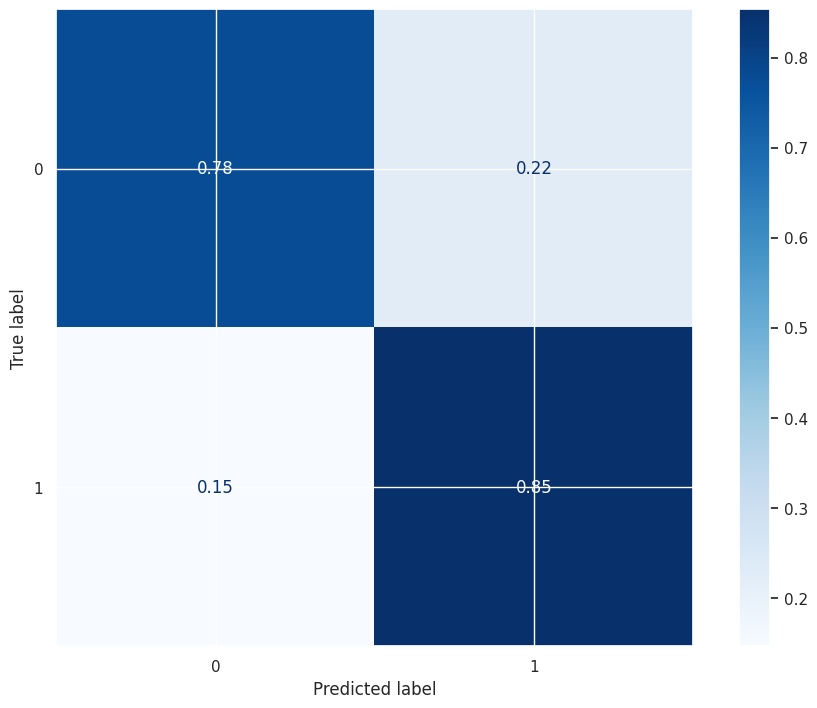

In [ ]:
#feature selection
#selection with mean
sel = SelectFromModel(RandomForestClassifier(n_estimators=1000, max_features = 'sqrt',ccp_alpha = 0.001,max_depth = 5, criterion ='entropy',class_weight='balanced'), threshold='mean')
sel.fit(X_train, y_train)
X_train_pd = pd.DataFrame(X_train)
selected_feat= X_train_pd.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

X_train_selected = sel.transform(X_train)
X_val_selected = sel.transform(X_val)
forest_opt.fit(X_train_selected, y_train)
Y_pred_train = forest_opt.predict(X_train_selected)
train_accuracy = metrics.balanced_accuracy_score(y_train, Y_pred_train)
Y_pred_val=forest_opt.predict(X_val_selected)
val_accuracy = metrics.balanced_accuracy_score(y_val, Y_pred_val)
F2_score = metrics.fbeta_score(y_val, Y_pred, beta=2)
print("Train balanced Accuracy {:.4f} ".format(train_accuracy))
print("Validation balanced Accuracy {:.4f} ".format(val_accuracy))
print("Validation F1 score {:.4f} ".format(F2_score))
confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(y_val, Y_pred_val, normalize='true', cmap='Blues')

24
Index([  2,   3,   4,  66,  67,  68,  74,  75, 139, 177, 451, 514, 523, 524,
       525, 526, 527, 528, 532, 533, 534, 535, 536, 537],
      dtype='int64')
Train balanced Accuracy 0.8407 
Validation balanced Accuracy 0.8131 
Validation F1 score 0.6323 


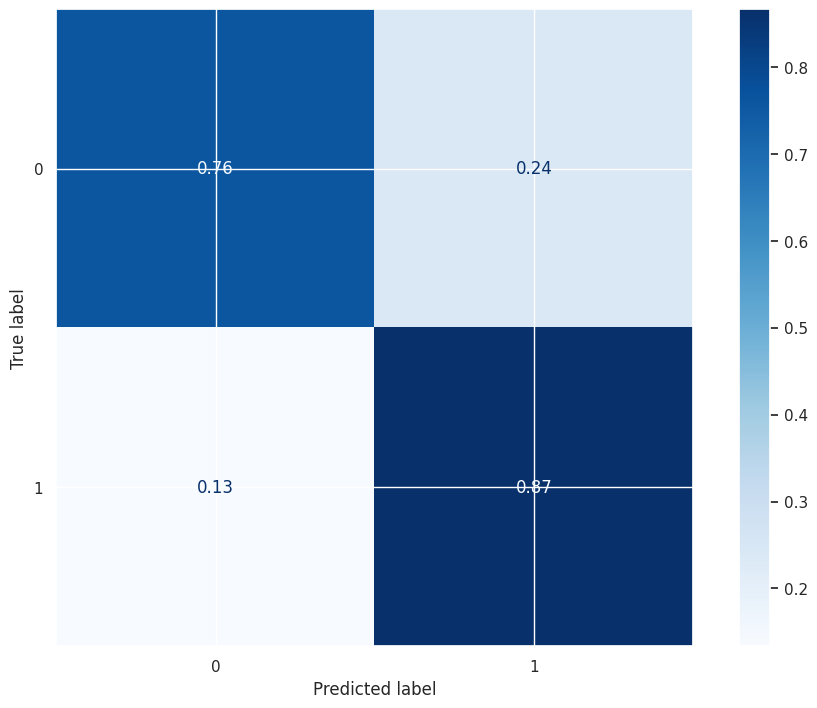

In [ ]:
#feature selection
#selection with 0.01
sel = SelectFromModel(RandomForestClassifier(n_estimators=1000, max_features = 'sqrt',ccp_alpha = 0.001,max_depth = 5, criterion ='entropy',class_weight='balanced'), threshold=0.01)
sel.fit(X_train, y_train)
X_train_pd = pd.DataFrame(X_train)
selected_feat= X_train_pd.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

X_train_selected = sel.transform(X_train)
X_val_selected = sel.transform(X_val)
forest_opt.fit(X_train_selected, y_train)
Y_pred_train = forest_opt.predict(X_train_selected)
train_accuracy = metrics.balanced_accuracy_score(y_train, Y_pred_train)
Y_pred_val=forest_opt.predict(X_val_selected)
val_accuracy = metrics.balanced_accuracy_score(y_val, Y_pred_val)
F2_score = metrics.fbeta_score(y_val, Y_pred, beta=2)
print("Train balanced Accuracy {:.4f} ".format(train_accuracy))
print("Validation balanced Accuracy {:.4f} ".format(val_accuracy))
print("Validation F1 score {:.4f} ".format(F2_score))
confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(y_val, Y_pred_val, normalize='true', cmap='Blues')

['Green Pixels too lenient', 'Green Pixels too strict', 'Colour Histogram 68', 'Colour Histogram 4', 'RGBVI', 'GLI', 'VARI', 'Hu Moments 4', 'Colour Histogram 3', 'Colour Histogram 76', 'Colour Histogram 69', 'Hu Moments 1', 'Colour Histogram 5', 'NGRDI', 'Hu Moments 2']
Green Pixels too lenient    0.086674
Green Pixels too strict     0.073947
Colour Histogram 68         0.060381
Colour Histogram 4          0.059303
RGBVI                       0.050193
GLI                         0.043429
VARI                        0.038133
Hu Moments 4                0.028556
Colour Histogram 3          0.027321
Colour Histogram 76         0.027164
Colour Histogram 69         0.025663
Hu Moments 1                0.025424
Colour Histogram 5          0.023170
NGRDI                       0.019153
Hu Moments 2                0.018586
dtype: float64


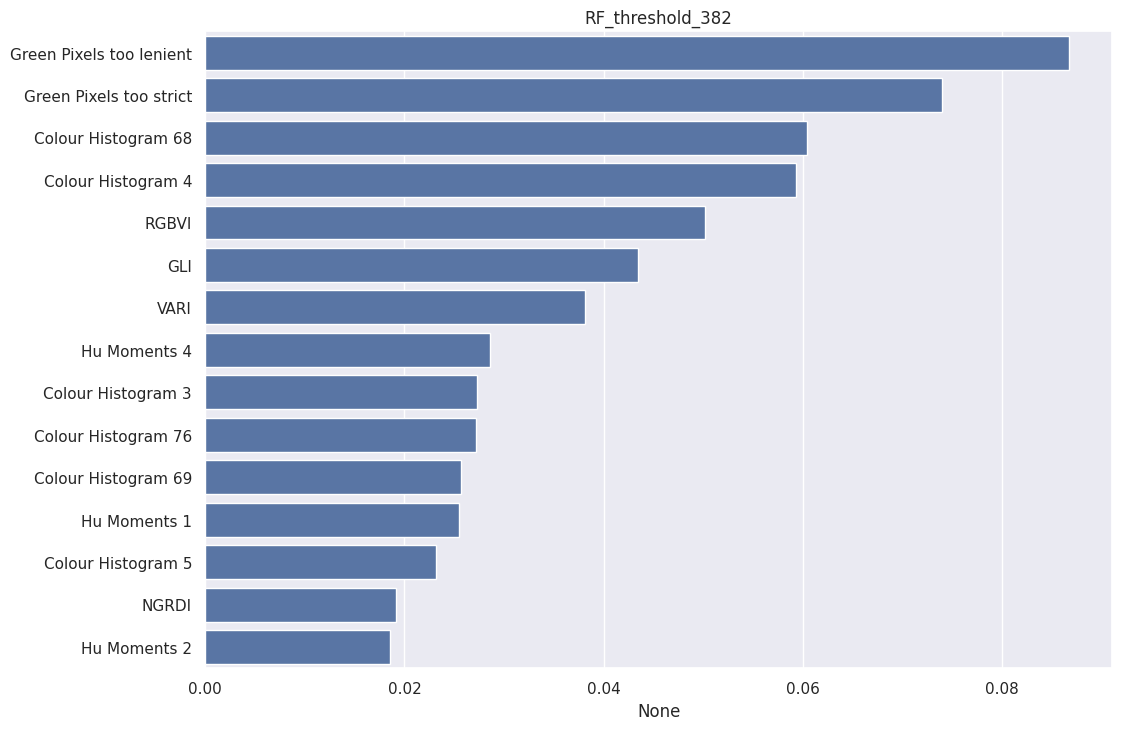

In [ ]:
# Representing feature importance
#names
histo_names = [f"Colour Histogram {i}" for i in range(1,513)]
haralick_names = [f"Haralick Texture {i}" for i in range(1,14)]
Hu_names = [f"Hu Moments {i}" for i in range(1,8)]
Greenpix_names = ['Green Pixels too strict', 'Green Pixels too lenient']
Veg_names = ['RGBVI', 'GLI', 'VARI', 'NGRDI']
feature_names = histo_names + haralick_names + Hu_names + Greenpix_names + Veg_names
feature_names_pd = pd.DataFrame(data=feature_names)
#importances
forest_opt= RandomForestClassifier(n_estimators=1000, max_features = 'sqrt',ccp_alpha = 0.01,max_depth = 5, criterion ='entropy',class_weight='balanced' )
forest_opt.fit(X_train, y_train)
importances = forest_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_opt.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
sorted_indices = forest_importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = forest_importances[sorted_indices]
Important_feat_names = sorted_feature_names[0:15]
Important_feat_importance = sorted_importances[0:15]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=Important_feat_importance, y=Important_feat_names)
plt.title('RF_threshold_382')

print(Important_feat_names)
print(Important_feat_importance)

## Testing optimal version of model

In [ ]:
#importing test set
test_path = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Test'

In [ ]:
#Extracting features and combining with DMY values test set
#creating datasets
# read the test data labels
test_labels = os.listdir(test_path)
# sort the test labesl
test_labels.sort()
# empty list to hold feature vectors and labels
features_test = []
y_values_test = []

# loop over the test data sub folder
for test_name in test_labels:
  # join the test data path and each test folder
  dir = os.path.join(test_path, test_name)

  # loop over the images in each sub-folder

  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:y= int(DMY[index])
    except ValueError:y=-1
    if y>=threshold: y = 1
    elif y>-1 and y<threshold: y = 0

    file = dir + "/" + os.fsdecode(file)
    # read the image and compute features
    image = cv2.imread(file)

    image = cv2.resize(image,tuple((51, 51)))
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image)
    fv_greenpixels= fd_greenpixels(image)
    fv_vegindices = fd_vegindices(image)

    # Concatenate global features
    global_feature = np.hstack([fv_histogram,fv_haralick, fv_hu_moments,fv_greenpixels, fv_vegindices])

    # update the list of labels and feature vectors
    if (y>-1):
      y_values_test.append(y)
      features_test.append(global_feature)

print("Completed Test Set Feature Extraction...")

#creating datasets
X_test=np.array(features_test)
y_test = y_values_test

#Combining train and validation set to use both as a train set for the final model
X_train_full = np.vstack((X_train,X_val))
y_train_full = y_train+y_val

Completed Test Set Feature Extraction...


Train balanced Accuracy 0.8430 
Validation balanced Accuracy 0.7760 
Validation F2 score 0.5830 


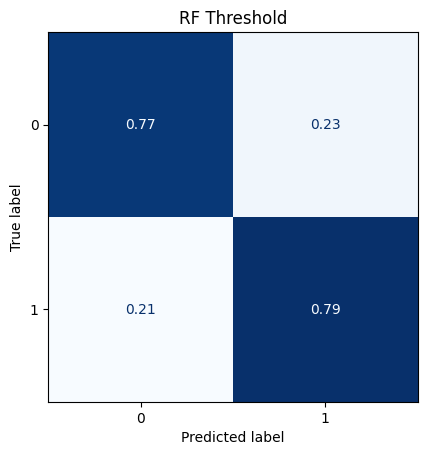

In [ ]:
#Training and testing model
forest_opt= RandomForestClassifier(n_estimators=1000, max_features='sqrt', criterion = 'entropy',max_depth=5,ccp_alpha=0.001 ,class_weight='balanced')
forest_opt.fit(X_train_full, y_train_full)

Y_pred_train = forest_opt.predict(X_train_full)
train_accuracy = metrics.balanced_accuracy_score(y_train_full, Y_pred_train)
Y_pred=forest_opt.predict(X_test)
val_accuracy = metrics.balanced_accuracy_score(y_test, Y_pred)
F2_score = metrics.fbeta_score(y_test, Y_pred, beta=2)
print("Train balanced Accuracy {:.4f} ".format(train_accuracy))
print("Validation balanced Accuracy {:.4f} ".format(val_accuracy))
print("Validation F2 score {:.4f} ".format(F2_score))
confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(y_test, Y_pred, normalize='true', cmap='Blues', colorbar=False)
plt.title('RF Threshold')
plt.show()